In [1]:
import collections
import h5py
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
from torch import nn, optim
import torch.nn.functional as F

from uuid import uuid4

print(f"cuda available: {torch.cuda.is_available()}")
print(f"torch version: {torch.__version__}")
print(f"numpy version: {np.__version__}")

cuda available: False
torch version: 2.1.0
numpy version: 1.26.0


In [315]:
from functools import wraps
import collections

# Stores accumulated running time in micros of functions annotated with @timing.
_PERF_ACC_MICROS = collections.Counter()
_PERF_COUNTS = collections.Counter()


def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        t_start = time.perf_counter_ns()
        result = f(*args, **kw)
        t_end = time.perf_counter_ns()
        name = f.__qualname__
        _PERF_ACC_MICROS[name] += (t_end - t_start) // 1000
        _PERF_COUNTS[name] += 1
        return result
    return wrap


def clear_perf_stats():
    _PERF_ACC_MICROS.clear()
    _PERF_COUNTS.clear()
    
    
def perf_stats():
    ms = _PERF_ACC_MICROS
    ns = _PERF_COUNTS
    width = max(len(k) for k in ms)
    print(f"{'method'.ljust(width)} {'total_sec':>11} {'count':>10} {'ops/s':>10}")
    for k in _PERF_ACC_MICROS:
        print(f"{k.ljust(width)} {ms[k]/1e6:>10.3f}s {ns[k]: 10} {ns[k]/(ms[k]/1e6):>10.1f}")
    

# Hexz

A board is represented by an (N, 10, 11) numpy array. Each 10x11 slice is a one-hot encoding of the presence of specific type of piece/obstacle/etc. The slices are:

* 0: flags by P1
* 1: cell value 1-5 for P1
* 2: cells blocked for P1 (any occupied cell or a cell next to a 5)
* 3: next value for P1 
* 4: flags by P2
* 5: cell value 1-5 for P2
* 6: cells blocked for P2
* 7: next value for P2
* 8: grass cells with value 1-5

An action is specified by a (2, 10, 11) numpy array. The first 10x11 slice represents a flag move,
the second one represents a regular cell move. A flag move must have a single 1 set, a normal move
must have a single value 1-5 set.

In [2]:
def valid_idx(r_c):
    """Returns True if (r, c) = r_c represents a valid hexz board index."""
    r, c = r_c
    return r >= 0 and r < 11 and c >= 0 and c < 10-r%2


def neighbors_map():
    """Returns a dict mapping all valid (r, c) indices to their neighbor indices.
    
    The neighbor indices are represented as (row, column) tuples."""
    result = {}
    for r in range(11):
        shift = r%2 # Depending on the row, neighbors below and above are shifted.
        for c in range(10-r%2):
            ns = filter(valid_idx, [
                (r, c+1),
                (r-1, c+shift),
                (r-1, c-1+shift),
                (r, c-1),
                (r+1, c-1+shift),
                (r+1, c+shift),
            ])
            nr, nc = zip(*ns)  # unzip
            result[(r, c)] = (np.array(nr), np.array(nc))
            
    return result


## Cython

When profiling the pure Python implementation of Board I found that `make_move` takes up most of the time of a random game. `make_move` is a fundamental operation in the game and shouldn't take any time: it only updates a few specific elements of the ndarray.

So here is an implementation in Cython. A naive implementation of fully playing a random game drops from 839 µs to 605 µs when using the Cython implementation. Effectively, the time spent in `make_move` becomes entirely negligible, as it should be.

In [ ]:
%load_ext Cython

In [335]:
 %%cython

import numpy as np

    
def c_valid_idx(r_c):
    """Returns True if (r, c) = r_c represents a valid hexz board index."""
    r, c = r_c
    return r >= 0 and r < 11 and c >= 0 and c < 10-r%2


def c_neighbors_map():
    """Returns a dict mapping all valid (r, c) indices to their neighbor indices.
    
    The neighbor indices are represented as (row, column) tuples."""
    result = {}
    for r in range(11):
        shift = r%2 # Depending on the row, neighbors below and above are shifted.
        for c in range(10-r%2):
            ns = filter(c_valid_idx, [
                (r, c+1),
                (r-1, c+shift),
                (r-1, c-1+shift),
                (r, c-1),
                (r+1, c-1+shift),
                (r+1, c+shift),
            ])
            nr, nc = zip(*ns)  # unzip
            result[(r, c)] = (np.array(nr), np.array(nc))
            
    return result


C_NEIGHBORS = c_neighbors_map()


def c_occupy_grass(board, int player, int r, int c):
    """Occupies the neighboring grass cells of move_idx (a 3-tuple index into a move) for player.

    Expects that the move has already been played.
    """
    cdef float[:, :, :] b = board.b
    cdef Py_ssize_t i = 0
    cdef Py_ssize_t x = 0
    cdef Py_ssize_t y = 0
    
    nx, ny = C_NEIGHBORS[(r, c)]
    for i in range(len(nx)):
        x = nx[i]
        y = ny[i]
        grass_val = b[8, x, y]
        if grass_val > 0 and grass_val <= b[1 + player*4, r, c]:
            # Occupy: first remove grass
            b[8, x, y] = 0                
            # the rest is exactly like playing a move.
            c_make_move(board, player, (1, r, c, grass_val))


def c_make_move(board, int player, move):
    """Makes the given move.

    Args:
      board: the board as an (N, 11, 10) ndarray.
      player: 0 or 1
      move: a 4-tuple of (typ, r, c, val), where typ = 0 (flag) or 1 (normal)
    Does not check that it is a valid move. Should be called only
    with moves returned from `next_moves`.
    """
    cdef float[:, :, :] b = board.b
    cdef Py_ssize_t typ = move[0]
    cdef Py_ssize_t r = move[1]
    cdef Py_ssize_t c = move[2]
    cdef double val = move[3]
    cdef double next_val = 0
    cdef Py_ssize_t i = 0
    
    b[typ + player*4, r, c] = val
    played_flag = typ == 0
    # Block played cell for both players.
    b[2, r, c] = 1
    b[6, r, c] = 1
    # Set next value to 0 for occupied cell.
    b[3, r, c] = 0
    b[7, r, c] = 0
    # Block neighboring cells if a 5 was played.
    nx, ny = C_NEIGHBORS[(r, c)]
    # Update next value of neighboring cells. If we played a flag, the next value is 1.
    if played_flag:
        next_val = 1
        board.nflags[player] -= 1
    else:
        next_val = val + 1
    if next_val <= 5:
        for nr, nc in zip(nx, ny):
            if b[2 + player*4, nr, nc] == 0:
                if next_val > 5:
                    b[3 + player*4, nr, nc] = 0
                if b[3 + player*4, nr, nc] == 0:
                    b[3 + player*4, nr, nc] = next_val
                elif b[3 + player*4, nr, nc] > next_val:
                    b[3 + player*4, nr, nc] = next_val
    else:
        for i in range(len(nx)):
            # Played a 5: block neighboring cells and clear next value.
            b[2 + player*4, nx[i], ny[i]] = 1
            b[3 + player*4, nx[i], ny[i]] = 0  # Clear next value.
    if not played_flag:
        c_occupy_grass(board, player, r, c)



Content of stderr:
/Users/denniswalter/.cache/ipython/cython/_cython_magic_8b79a2fdf4dce63b414f4d488db17765cf546584.c:5645:28: warning: equality comparison with extraneous parentheses [-Wparentheses-equality]
  if (((__pyx_v_c_mode[0]) == 'f')) {
       ~~~~~~~~~~~~~~~~~~~~^~~~~~
/Users/denniswalter/.cache/ipython/cython/_cython_magic_8b79a2fdf4dce63b414f4d488db17765cf546584.c:5645:28: note: remove extraneous parentheses around the comparison to silence this warning
  if (((__pyx_v_c_mode[0]) == 'f')) {
      ~                    ^     ~
/Users/denniswalter/.cache/ipython/cython/_cython_magic_8b79a2fdf4dce63b414f4d488db17765cf546584.c:5645:28: note: use '=' to turn this equality comparison into an assignment
  if (((__pyx_v_c_mode[0]) == 'f')) {
                           ^~
                           =
1 warning generated.
ld: warning: duplicate -rpath '/Users/denniswalter/miniconda3/lib' ignored

In [336]:
class PurePyBoard:
    """Numpy representation of a hexz board."""

    # Used to quickly get the indices of neighbor cells.
    neighbors = neighbors_map()
    
    def __init__(self, other=None):
        """Generates a new randomly initialized board or returns a copy of other, if set."""
        if other:
            self.b = other.b.copy()
            self.nflags = list(other.nflags)
            return
        self.b = np.zeros((9, 11, 10), dtype=np.float32)
        self.nflags = [3, 3]  # number of flags remaining per player
        # Even rows have 10 cells, odd rows only 9, so mark the last cell in odd rows as blocked for P1+P2.
        self.b[2, [1, 3, 5, 7, 9], 9] = 1
        self.b[6, [1, 3, 5, 7, 9], 9] = 1        
        # 2-tuple of valid indices in each slice.
        free_cells = (1 - self.b[2]).nonzero()
        # 15 randomly placed stones.
        rng = np.random.default_rng()
        stones = rng.choice(np.arange(0, len(free_cells[0])), replace=False, size=15)
        self.b[2, free_cells[0][stones], free_cells[1][stones]] = 1
        self.b[6, free_cells[0][stones], free_cells[1][stones]] = 1
        free_cells = (1 - self.b[2]).nonzero()
        # 5 grass cells
        grass = rng.choice(np.arange(0, len(free_cells[0])), replace=False, size=5)
        self.b[8, free_cells[0][grass], free_cells[1][grass]] = [1, 2, 3, 4, 5]
        self.b[2, free_cells[0][grass], free_cells[1][grass]] = 1
        self.b[6, free_cells[0][grass], free_cells[1][grass]] = 1
    
    def quickview(self):
        """Returns a single slice of the board with different cell types encoded as -/+ numbers."""
        return (self.b[0] * 8) + self.b[1] - (self.b[4] * 8) - self.b[5]
        
    def score(self):
        """Returns the current score as a 2-tuple."""
        return (self.b[1].sum(), self.b[5].sum())
    
    def result(self):
        """Returns the final result of the board.
        
        1 (player 0 won), 0 (draw), -1 (player 1 won).
        """
        p0, p1 = self.score()
        return np.sign(p0 - p1)
        
    def make_move(self, player, move):
        """Makes the given move.
        
        Args:
          player: 0 or 1
          move: a 4-tuple of (typ, r, c, val), where typ = 0 (flag) or 1 (normal)
        Does not check that it is a valid move. Should be called only
        with moves returned from `next_moves`.
        """
        typ, r, c, val = move
        b = self.b
        b[typ + player*4, r, c] = val
        played_flag = typ == 0
        # Block played cell for both players.
        b[2, r, c] = 1
        b[6, r, c] = 1
        # Set next value to 0 for occupied cell.
        b[3, r, c] = 0
        b[7, r, c] = 0
        # Block neighboring cells if a 5 was played.
        nx, ny = Board.neighbors[(r, c)]
        # Update next value of neighboring cells. If we played a flag, the next value is 1.
        if played_flag:
            next_val = 1
            self.nflags[player] -= 1
        else:
            next_val = val + 1
        if next_val <= 5:
            for nr, nc in zip(nx, ny):
                if b[2 + player*4, nr, nc] == 0:
                    if next_val > 5:
                        b[3 + player*4, nr, nc] = 0
                    if b[3 + player*4, nr, nc] == 0:
                        b[3 + player*4, nr, nc] = next_val
                    elif b[3 + player*4, nr, nc] > next_val:
                        b[3 + player*4, nr, nc] = next_val
        else:
            # Played a 5: block neighboring cells and clear next value.
            b[2 + player*4, nx, ny] = 1
            b[3 + player*4, nx, ny] = 0  # Clear next value.

        # Occupy neighboring grass cells.
        if not played_flag:
            self.occupy_grass(player, r, c)
            
    def occupy_grass(self, player, r, c):
        """Occupies the neighboring grass cells of move_idx (a 3-tuple index into a move) for player.
        
        Expects that the move has already been played.
        """
        nx, ny = Board.neighbors[(r, c)]
        for i, j in zip(nx, ny):
            grass_val = self.b[8, i, j]
            if grass_val > 0 and grass_val <= self.b[1 + player*4, r, c]:
                # Occupy: first remove grass
                self.b[8, i, j] = 0                
                # the rest is exactly like playing a move.
                self.make_move(player, (1, r, c, grass_val))
    
    @timing
    def next_moves(self, player):
        """Returns all possible next moves.
        
        A move is represented as a (2, 11, 10) ndarray. The first slice represents
        flag moves, the second one represents normal moves. A flag move will have exactly
        one element set to 1 in slice 0. A normal move will have exactly one element set to
        1-5 in slice 1.
        """
        moves = []
        # Do we have unoccupied cells and flags left? Then we can place another one.
        if self.nflags[player] > 0:
            # Flag in any unoccupied cell.
            rs, cs = np.nonzero(self.b[2 + player*4] == 0)  # funky way to get indices for all free cells.
            moves.extend((0, r, c, 1) for r, c in zip(rs, cs))
        # Collect all cells with a non-zero next value.
        rs, cs = np.nonzero(self.b[3 + player*4])
        moves.extend((1, r, c, self.b[3 + player*4, r, c]) for r, c in zip(rs, cs))
        return moves

    
class CBoard(PurePyBoard):
    """Like a PurePyBoard, but uses the fast C implementations where available."""
    @timing
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    @timing
    def make_move(self, player, move):
        c_make_move(self, player, move)
        
    @timing
    def occupy_grass(self, player, r, c):
        c_occupy_grass(self, player, r, c)

        
# Use the C implementation.
Board = CBoard

In [337]:
%%timeit

for i in range(1):
    rng = np.random.default_rng()
    b = Board()
    player = 0
    moves = b.next_moves(player)
    num_moves = 0
    while moves and num_moves < 200:
        m = moves[rng.integers(0, len(moves))]
        b.make_move(player, m)
        num_moves += 1
        player = 1 - player
        moves = b.next_moves(player)
        if not moves:
            # No more moves for the player. See if the other player can continue.
            player = 1 - player
            moves = b.next_moves(player)
    # print(f"Done after {num_moves} moves. Flags left: {b.nflags}. Score: {b.score()}")
    # b.quickview()

862 µs ± 2.34 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [170]:
class Node:
    """Nodes of the MCTS tree."""
    def __init__(self, parent, player, move):
        self.parent = parent
        self.player = player
        self.move = move
        self.wins = 0.0
        self.visit_count = 0
        self.children = []
    
    def uct(self):
        if self.parent.visit_count == 0:
            return 0.5
        if self.visit_count == 0:
            win_rate = 0.5
            adjusted_count = 1
        else:
            win_rate = self.wins / self.visit_count
            adjusted_count = self.visit_count
        return (
            win_rate + 
            1.0 * np.sqrt(np.log(self.parent.visit_count) / adjusted_count)
        )

    def __str__(self):
        return f"Node(p={self.player}, m={self.move}, w={self.wins/self.visit_count:.3f}, n={self.visit_count}, u={self.uct():.3f}, cs={len(self.children)})"

    def __repr__(self):
        return str(self)
    
    def move_likelihoods(self):
        """Returns the move likelihoods for all children as a (2, 11, 10) ndarray.
        
        The ndarray indicates the likelihoods (based on visit count) for flags
        and normal moves. It sums to 1.
        """
        p = np.zeros((2, 11, 10))
        for child in self.children:
            typ, r, c, _ = child.move
            p[typ, r, c] = child.visit_count
        return p / p.sum()
    
    def best_child(self):
        """Returns the best among all children.
        
        The best child is the one with the greatest visit count, a common
        choice in the MCTS literature.
        """
        return max(self.children, default=None, key=lambda n: n.visit_count)
    

class Example:
    """Data holder for one step of a fully played MCTS game."""
    
    def __init__(self, game_id, board, move_probs, turn, result):
        """
        Args:
            game_id: arbitrary string identifying the game that this example belongs to.
            board: the board (Board.b) as an (N, 11, 10) ndarray.
            move_probs: (2, 11, 10) ndarray of move likelihoods.
            turn: 0 or 1, indicating which player's turn it was.
            result: -1, 0, 1, indicating the player that won (1 = player 0 won).
        """
        self.game_id = game_id
        self.board = board
        self.move_probs = move_probs
        self.turn = turn
        self.result = result
    
    @classmethod
    def save_all(self, path, examples, mode="a"):
        """Saves the examples in a HDF5 file at the given path.
        
        Args:
            path: a file path, e.g. "/path/to/examples.h5"
            examples: a list of Example instances.
            mode: 'a' (the default) to append or create, 'w' to truncate or create.
        """
        with h5py.File(path, mode) as h5:
            offset = len(h5)
            for i, ex in enumerate(examples):
                grp = h5.create_group(f"{i+offset:08}")
                grp.attrs["game_id"] = ex.game_id
                grp.create_dataset("board", data=ex.board)
                grp.create_dataset("move_probs", data=ex.move_probs)
                grp.create_dataset("turn", data=np.array([ex.turn]))
                grp.create_dataset("result", data=np.array([ex.result]))
    
    @classmethod
    def load_all(cls, path):
        """This method is for testing only.
        
        Use a HexzDataset to access the examples from PyTorch."""
        examples = []
        with h5py.File(path, "r") as h5:
            for grp in h5:
                ex = h5[grp]
                turn = ex["turn"][0]
                result = ex["result"][0]
                examples.append(
                    Example(ex.attrs["game_id"], ex["board"][:], ex["move_probs"][:], turn, result)
                )
        return examples
        
        
class MCTS:
    """Monte Carlo tree search."""
    def __init__(self, board, game_id=None):
        self.board = board
        # In the root node it's player 1's "fake" turn. 
        # This has the desired effect that the root's children will play
        # as player 0, who makes the first move.
        self.root = Node(None, 1, None)
        self.rng = np.random.default_rng()
        if not game_id:
            game_id = uuid4().hex[:12]
        self.game_id = game_id
        
    def rollout(self, board, player):
        """Play a random game till the end, starting with board and player on the move."""
        for i in range(200):
            moves = board.next_moves(player)
            if not moves:
                # No more moves for the player. See if the other player can continue.
                player = 1 - player
                moves = board.next_moves(player)
            if not moves:
                return board.result()
            b.make_move(player, moves[self.rng.integers(0, len(moves))])
            player = 1 - player
        raise ValueError("Never finished rollout")

    def backpropagate(self, node, result):
        while node:
            node.visit_count += 1
            if node.player == 0:
                node.wins += (result + 1) / 2
            else:
                node.wins += (-result + 1) / 2
            node = node.parent

    def size(self):
        q = [self.root]
        s = 0
        while q:
            n = q.pop()
            s += 1
            q.extend(n.children)
        return s
        
    def run(self):
        """Runs a single round of the MCTS loop."""
        b = Board(self.board)
        n = self.root
        # Find leaf node.
        while n.children:
            best = None
            best_uct = -1
            for c in n.children:
                c_uct = c.uct()
                if c_uct > best_uct:
                    best = c
                    best_uct = c_uct
            b.make_move(best.player, best.move)
            n = best
        # Reached a leaf node: expand
        player = 1 - n.player  # Usually it's the other player's turn.
        moves = b.next_moves(player)
        if not moves:
            # No more moves for player. Try other player.
            player = 1 - player
            moves = b.next_moves(player)
        if not moves:
            # Game is over
            self.backpropagate(n, b.result())
            return
        # Rollout time!
        for move in moves:
            n.children.append(Node(n, player, move))
        c = n.children[self.rng.integers(0, len(n.children))]
        b.make_move(c.player, c.move)
        result = self.rollout(b, 1 - c.player)
        self.backpropagate(c, result)
        
    def play_game(self, runs_per_move=500):
        """Plays one full game and returns the move likelihoods per move and the final result.
        
        Args:
            runs_per_move: number of MCTS runs to make per move.
        """
        examples = []
        result = None
        n = 0
        started = time.perf_counter()
        while n < 200:
            for i in range(runs_per_move):
                self.run()
            best_child = self.root.best_child()
            if not best_child:
                # Game over
                result = self.board.result()
                break
            examples.append(Example(self.game_id, self.board.b.copy(), 
                                    self.root.move_likelihoods(), best_child.player, None))
            # Make the move.
            self.board.make_move(best_child.player, best_child.move)
            self.root = best_child
            self.root.parent = None  # Allow GC and avoid backprop further up.
            if n < 5 or n%10 == 0:
                print(f"Iteration {n}: visit_count:{best_child.visit_count} ",
                      f"move:{best_child.move} player:{best_child.player} score:{self.board.score()}")
            n += 1
        if n == 200:
            raise ValueError(f"Iterated {n} times. Something's fishy.")
        elapsed = time.perf_counter() - started
        print(f"Done in {elapsed:.3f}s after {n} moves. Final score: {self.board.score()}.")
        # Update all examples with result.
        for ex in examples:
            ex.result = result
        return examples


In [ ]:
%%prun

b = Board()
m = MCTS(b)
for _ in range(1000):
    m.run()
# m.root.children

In [338]:
m = MCTS(Board())
xs = m.play_game(10)

Iteration 0: visit_count:3  move:(0, 0, 5, 1) player:0 score:(0.0, 0.0)
Iteration 1: visit_count:3  move:(0, 0, 2, 1) player:1 score:(0.0, 0.0)
Iteration 2: visit_count:3  move:(0, 0, 3, 1) player:0 score:(0.0, 0.0)
Iteration 3: visit_count:3  move:(0, 0, 6, 1) player:1 score:(0.0, 0.0)
Iteration 4: visit_count:3  move:(0, 1, 2, 1) player:0 score:(0.0, 0.0)
Iteration 10: visit_count:4  move:(1, 2, 3, 1.0) player:0 score:(3.0, 2.0)
Iteration 20: visit_count:4  move:(1, 2, 0, 3.0) player:0 score:(12.0, 9.0)
Iteration 30: visit_count:6  move:(1, 5, 3, 4.0) player:0 score:(26.0, 24.0)
Iteration 40: visit_count:6  move:(1, 5, 2, 4.0) player:0 score:(44.0, 46.0)
Done in 0.133s after 46 moves. Final score: (55.0, 51.0).


In [339]:
Example.save_all("test32.h5", xs)

In [342]:
Example.load_all("test32.h5")[0].board.dtype

dtype('float32')

In [197]:
class HexzDataset(torch.utils.data.Dataset):
    """PyTorch Dataset implementation to read Hexz samples from HDF5."""
    def __init__(self, path):
        self.h5 = h5py.File(path, "r")
        self.length = len(self.h5)
        self.keys = list(self.h5.keys())
        
    def __getitem__(self, k):
        """Returns the board as the X and two labels: move likelihoods (2, 11, 10) and (1) result.
        
        The collation function the PyTorch DataLoader handles this properly and returns a tuple
        of batches for the labels.
        """
        data = self.h5[self.keys[k]]
        # data["turn"][0] ignored for now.
        return data["board"][:], (data["move_probs"][:], data["result"][:])

    def __len__(self):
        return self.length
        

In [198]:
# Now we can use the standard torch DataLoader to iterate over our samples.
batch_size = 16

ds = HexzDataset("test.h5")
loader = torch.utils.data.DataLoader(dataset=ds, batch_size=batch_size, shuffle=True)
for X, (y_pr, y_val) in loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}: {X.dtype}")
    print(f"Shape of y_pr [N, C, H, W]: {y1.shape}: {y1.dtype}")
    print(f"Shape of y_val [N, V]: {y2.shape}: {y2.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([16, 9, 11, 10]): torch.float64
Shape of y_pr [N, C, H, W]: torch.Size([64, 2, 11, 10]): torch.float64
Shape of y_val [N, V]: torch.Size([64, 1]): torch.float64


In [210]:
class HexzNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        board_channels = 9
        cnn_channels = 32
        self.features = nn.Sequential(
            # First CNN layer
            nn.Conv2d(board_channels, cnn_channels, kernel_size=3),  # [N, cnn_channels, 11-2, 10-2]
            nn.BatchNorm2d(cnn_channels), 
            nn.ReLU(),
            # Second CNN layer
            nn.Conv2d(cnn_channels, cnn_channels, kernel_size=3),  # # [N, cnn_channels, 7, 6]
            nn.BatchNorm2d(cnn_channels),
            nn.ReLU(),
        )
        fc_size = 256
        self.fc = nn.Sequential(
            nn.Linear(cnn_channels * 7 * 6, fc_size),
            nn.BatchNorm1d(fc_size), 
            nn.ReLU(),
            nn.Linear(fc_size, fc_size),
        )
        self.move_probs = nn.Linear(fc_size, 2 * 11 * 10)
        self.value = nn.Linear(256, 1)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        pi = self.move_probs(x)
        v = self.value(x)
        return F.log_softmax(pi, dim=1), torch.tanh(v)


In [202]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model = HexzNeuralNetwork().to(device)
print(model)

Using mps device
HexzNeuralNetwork(
  (features): Sequential(
    (0): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=1344, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (move_probs): Linear(in_features=256, out_features=220, bias=True)
  (value): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
pr_loss_fn = nn.CrossEntropyLoss()
val_loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

total_samples = len(loader.dataset)

for epoch in range(20):
    for batch, (X, (y_pr, y_val)) in enumerate(loader):
        started = time.perf_counter()
        # Convert inputs and send to device.
        X = X.to(device, dtype=torch.float32)
        y_pr = y_pr.to(device, dtype=torch.float32)
        y_val = y_val.to(device, dtype=torch.float32)

        # Predict
        pred_pr, pred_val = model(X)
        # print("Predicted value:", pred_val[0])
        # print("Predicted logits:", pred_pr.flatten(1)[0])

        # Compute loss
        pr_loss = pr_loss_fn(pred_pr.flatten(1), y_pr.flatten(1))
        val_loss = val_loss_fn(pred_val, y_val)
        loss = pr_loss + val_loss
        # print("Actual lekkers:", y_pr.flatten(1)[0])
        # print("Actual value:", y_val.flatten(1)[0])
        # print("Losses (pr, val):", pr_loss, val_loss)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        elapsed = time.perf_counter() - started
        print(f"batch {batch} in {elapsed:.3f}s")

        if True or batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{total_samples:>5d}]")
print("Done.")

In [345]:
from torch.profiler import profile, record_function, ProfilerActivity

In [348]:
class NNode:
    """Nodes of the NeuralMCTS tree."""
    def __init__(self, parent, player, move, move_probs, value):
        self.parent = parent
        self.player = player
        self.move = move
        self.wins = 0.0
        self.visit_count = 0
        self.children = []
        self.move_probs = move_probs
        self.value = value
    
    @timing
    def uct(self):
        typ, r, c, _ = self.move
        pvc = self.parent.visit_count
        vc = max(1, self.visit_count)
        return (
            self.value + 
            self.parent.move_probs[typ, r, c] * np.sqrt(np.log(pvc) / vc)
        )

    def __str__(self):
        return f"Node(p={self.player}, m={self.move}, w={self.wins/self.visit_count:.3f}, n={self.visit_count}, u={self.uct():.3f}, cs={len(self.children)})"

    def __repr__(self):
        return str(self)
    
    @timing
    def move_likelihoods(self):
        """Returns the move likelihoods for all children as a (2, 11, 10) ndarray.
        
        The ndarray indicates the likelihoods (based on visit count) for flags
        and normal moves. It sums to 1.
        """
        p = np.zeros((2, 11, 10))
        for child in self.children:
            typ, r, c, _ = child.move
            p[typ, r, c] = child.visit_count
        return p / p.sum()
    
    @timing
    def best_child(self):
        """Returns the best among all children.
        
        The best child is the one with the greatest visit count, a common
        choice in the MCTS literature.
        """
        return max(self.children, default=None, key=lambda n: n.visit_count)

        
class NeuralMCTS:
    """Monte Carlo tree search with a neural network (AlphaZero style)."""
    @timing
    def __init__(self, board, model, game_id=None):
        self.board = board
        self.model = model
        self.rng = np.random.default_rng()
        if not game_id:
            game_id = uuid4().hex[:12]
        self.game_id = game_id

        model.eval()  # Training is done outside of NeuralMCTS
        # Predict move probabilities for root up front.
        move_probs, val = self.predict(board)
        # In the root node it's player 1's "fake" turn. 
        # This has the desired effect that the root's children will play
        # as player 0, who makes the first move.
        self.root = NNode(None, 1, None, move_probs, val)
        # Manual profiling information. Looks like %prun does not work with Torch?
        
    @timing
    def backpropagate(self, node, result):
        while node:
            node.visit_count += 1
            if node.player == 0:
                node.wins += (result + 1) / 2
            else:
                node.wins += (-result + 1) / 2
            node = node.parent

    def size(self):
        q = [self.root]
        s = 0
        while q:
            n = q.pop()
            s += 1
            q.extend(n.children)
        return s
        
    @timing
    def predict(self, board):
        X = torch.from_numpy(board.b).to(device, dtype=torch.float32)
        with torch.no_grad():
            pred_pr, pred_val = self.model(torch.unsqueeze(X, 0))
            pred_pr = torch.exp(pred_pr).reshape((2, 11, 10))
            return pred_pr, pred_val.item()
    
    @timing
    def run(self):
        """Runs a single round of the neural MCTS loop."""
        b = Board(self.board)
        n = self.root
        # Find leaf node.
        while n.children:
            best = None
            best_uct = -1
            for c in n.children:
                c_uct = c.uct()
                if c_uct > best_uct:
                    best = c
                    best_uct = c_uct
            b.make_move(best.player, best.move)
            n = best
        # Reached a leaf node: expand
        player = 1 - n.player  # Usually it's the other player's turn.
        moves = b.next_moves(player)
        if not moves:
            # No more moves for player. Try other player.
            player = 1 - player
            moves = b.next_moves(player)
        if not moves:
            # Game is over
            self.backpropagate(n, b.result())
            return
        # Neural network time! Predict value and policy for each child.
        model = self.model
        for move in moves:
            cb = Board(b)
            cb.make_move(player, move)
            move_probs, val = self.predict(cb)
            n.children.append(NNode(n, player, move, move_probs, val))
        c = n.children[self.rng.integers(0, len(n.children))]
        b.make_move(c.player, c.move)
        self.backpropagate(c, c.value)
    
    def play_game(self, runs_per_move=500, max_moves=200):
        """Plays one full game and returns the move likelihoods per move and the final result.
        
        Args:
            runs_per_move: number of MCTS runs to make per move.
        """
        examples = []
        result = None
        n = 0
        started = time.perf_counter()
        with profile(activities=[ProfilerActivity.CPU]) as prof:
            with record_function("model_inference"):
                while n < max_moves:
                    for i in range(runs_per_move):
                        self.run()
                    best_child = self.root.best_child()
                    if not best_child:
                        # Game over
                        result = self.board.result()
                        break
                    examples.append(Example(self.game_id, self.board.b.copy(), 
                                            self.root.move_likelihoods(), best_child.player, None))
                    # Make the move.
                    self.board.make_move(best_child.player, best_child.move)
                    self.root = best_child
                    self.root.parent = None  # Allow GC and avoid backprop further up.
                    if n < 5 or n%10 == 0:
                        print(f"Iteration {n}: visit_count:{best_child.visit_count} ",
                              f"move:{best_child.move} player:{best_child.player} score:{self.board.score()}")
                    n += 1
        print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
        elapsed = time.perf_counter() - started
        if n == max_moves:
            print(f"Reached max iterations ({n}) after {elapsed:.3f}s. Returning early.")
            return []
        print(f"Done in {elapsed:.3f}s after {n} moves. Final score: {self.board.score()}.")
        # Update all examples with result.
        for ex in examples:
            ex.result = result
        return examples


In [4]:
import hexz
hexz.clear_perf_stats()

b = hexz.Board()
device = 'cpu'
model = hexz.HexzNeuralNetwork().to(device)
m = hexz.NeuralMCTS(b, model, "CPU")
for i in range(20):
    _ = m.run() # play_game(50, max_moves=1)

hexz.print_perf_stats()

method                   total_sec      count      ops/s
CBoard.__init__             0.002s         21     8872.0
NeuralMCTS.predict          0.026s         21      795.6
run_find_leaf               0.001s         20    18885.7
PurePyBoard.next_moves      0.001s         20    20876.8
NeuralMCTS.run              0.027s         20      736.1


In [333]:
perf_stats()

method                     total_sec      count      ops/s
CBoard.__init__               0.069s      26447   383668.0
NeuralMCTS.predict           51.600s      26147      506.7
NeuralMCTS.__init__           0.005s          1      182.4
PurePyBoard.next_moves        0.016s        300    18512.8
CBoard.make_move              0.099s      26910   273031.7
NeuralMCTS.backpropagate      0.001s        300   402144.8
NeuralMCTS.run               69.224s        300        4.3
NNode.uct                     5.550s      39710     7154.9
NNode.best_child              0.000s          3    66666.7
NNode.move_likelihoods        0.000s          3    21582.7


# LANDFILL

Text(0.5, 1.0, 'tanh(x)')

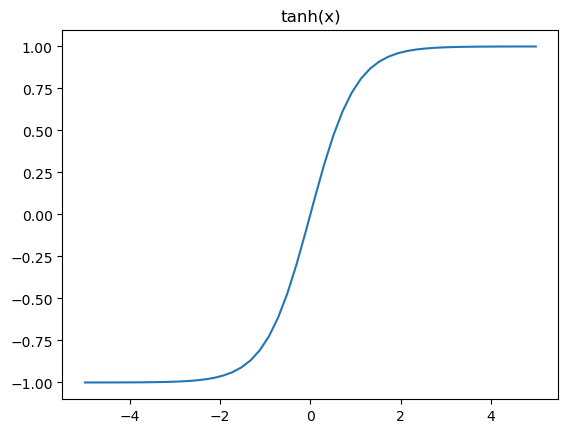

In [138]:
X = np.linspace(-5, 5)
Y = np.tanh(X)
plt.plot(X, Y)
plt.title("tanh(x)")

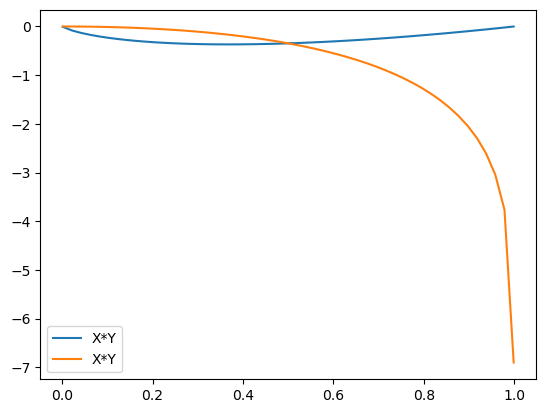

In [354]:
X = np.linspace(0.001, 0.999)
Y = np.log(X)
# plt.plot(X, Y, label='Y')
plt.plot(X, X*Y, label='X*Y')
plt.plot(X, X*np.log(1-X), label='X*Y')
plt.legend()

In [374]:
x = np.arange(9*11*10).reshape((9, 11, 10))
print(x.__array_interface__)
x[0:4], x[4:8] = x[4:8], x[0:4].copy()
print(x.__array_interface__)

{'data': (12114779648, False), 'strides': None, 'descr': [('', '<i8')], 'typestr': '<i8', 'shape': (9, 11, 10), 'version': 3}
{'data': (12114779648, False), 'strides': None, 'descr': [('', '<i8')], 'typestr': '<i8', 'shape': (9, 11, 10), 'version': 3}


In [376]:
x[[0,2]].__array_interface__

{'data': (5082323968, False),
 'strides': None,
 'descr': [('', '<i8')],
 'typestr': '<i8',
 'shape': (2, 11, 10),
 'version': 3}

In [390]:
x = np.arange(9*11*10).reshape((9, 11, 10))


In [392]:
%%timeit
x[0:4], x[4:8] = x[4:8], x[0:4].copy()

882 ns ± 3.89 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [393]:
%%timeit
y = x.copy()
y[0:4], y[4:8] = x[4:8], x[0:4]

955 ns ± 14.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [383]:
%%timeit
x[0:4, :, :], x[4:8, :, :] = x[4:8, :, :], x[0:4, :, :].copy()


1.52 µs ± 2.47 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [382]:
%%timeit
x[[0,1], :, :] = x[[1,0], :, :]


2.7 µs ± 9.37 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [387]:
class A:
    def __init__(self):
        self.x = 0
    def f(self):
        self.x += x + 1
class B(A):
    pass


        

In [388]:
%%timeit
a = A()
for i in range(1000):
    a.f()

1.26 ms ± 2.54 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [389]:
%%timeit
a = B()
for i in range(1000):
    a.f()

1.27 ms ± 6.51 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [50]:
# Distribution of move likelihoods of Go-generated samples.
# Goal: ensure we don't train the model with 95% samples that have a uniform likelihood for any move.
import hexz
import importlib
importlib.reload(hexz)


<module 'hexz' from '/Users/denniswalter/git/github.com/dnswlt/hexz/python/hexz.py'>

In [52]:
ds = hexz.HexzDataset("/Users/denniswalter/git/github.com/dnswlt/hexz-models/models/flagz/genesis/checkpoints/0/examples/examples-20231014-*.h5")

In [53]:
len(ds)

200714

In [54]:
sigmas = np.zeros(len(ds))
spreads = np.zeros(len(ds))
n = 0
for _, (p, _) in ds:
    v = p[p != 0]
    sigmas[n] = v.std()
    spreads[n] = v.max() - v.min()
    n += 1
    if n % 10000 == 0:
        print(f"Record {n}")

Record 10000
Record 20000
Record 30000
Record 40000
Record 50000
Record 60000
Record 70000
Record 80000
Record 90000
Record 100000
Record 110000
Record 120000
Record 130000
Record 140000
Record 150000
Record 160000
Record 170000
Record 180000
Record 190000
Record 200000


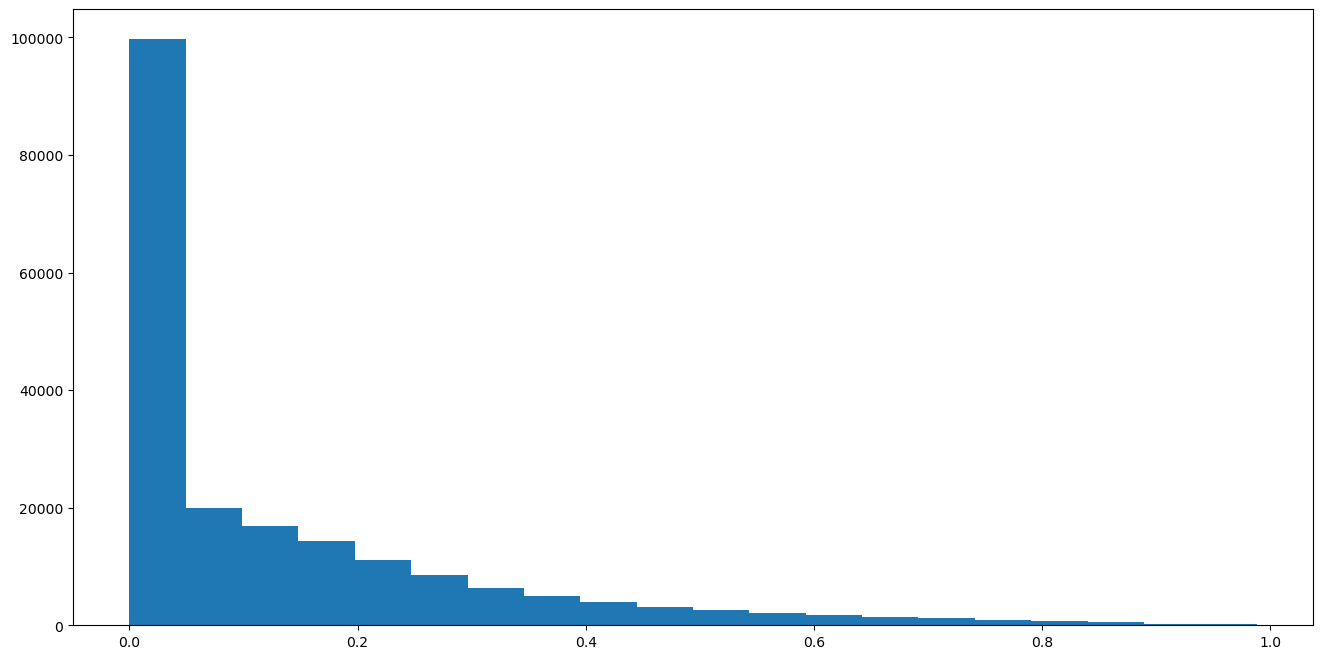

In [55]:
_, axs = plt.subplots(1, 1, figsize=(16,8))
# axs[0].hist(sigmas, bins=20)
_ = axs.hist(spreads, bins=20)

In [56]:
np.quantile(spreads * 100, q=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

array([0.00000000e+00, 1.00001693e-02, 5.05999960e+00, 1.95900008e+01,
       3.80499989e+01, 7.70099998e+01])

In [25]:
pd.DataFrame(spreads * 100).describe()

,0
count,50201.000000
mean,12.799569
std,17.775324
min,0.000000
25%,0.010000
50%,5.020000
75%,19.569999
max,97.799999


In [27]:
np.cumsum(np.arange(10))

array([ 0,  1,  3,  6, 10, 15, 21, 28, 36, 45])

In [29]:
np.arange(10).cumsum()


array([ 0,  1,  3,  6, 10, 15, 21, 28, 36, 45])

In [30]:
import bisect

In [39]:
end_idxs = list(np.array([100,200,300,400])-1)
end_idxs

[99, 199, 299, 399]

In [40]:
bisect.bisect_left(end_idxs, 100)

1

In [57]:
# Logits

In [82]:
X = np.random.uniform(size=20)
X /= X.sum()
X

array([0.05284067, 0.10513826, 0.09754083, 0.00689   , 0.00755812,
       0.00781413, 0.00210272, 0.05012355, 0.02839026, 0.07061776,
       0.08995955, 0.04996836, 0.04099045, 0.0012453 , 0.00424128,
       0.10929713, 0.09654028, 0.04091332, 0.07840272, 0.05942534])

In [99]:
P = np.random.uniform(size=20)

In [83]:
L = np.log(X/(1-X))
L2 = np.log(X)
Y = X
L, L2, Y

(array([-2.88618625, -2.14139301, -2.2248524 , -4.97077103, -4.87754618,
        -4.84397695, -6.16242079, -2.94184089, -3.53290813, -2.57723841,
        -2.31412896, -2.94510533, -3.15256189, -6.68713333, -5.45863952,
        -2.0979408 , -2.23627116, -3.15452588, -2.46424977, -2.76177034]),
 array([-2.9404742 , -2.25247906, -2.32748423, -4.97768487, -4.88513301,
        -4.85182177, -6.16452572, -2.99326425, -3.56170919, -2.65047358,
        -2.40839518, -2.99636531, -3.19441614, -6.68837941, -5.46288982,
        -2.21368518, -2.33779492, -3.19629969, -2.5458967 , -2.82303459]),
 array([0.05284067, 0.10513826, 0.09754083, 0.00689   , 0.00755812,
        0.00781413, 0.00210272, 0.05012355, 0.02839026, 0.07061776,
        0.08995955, 0.04996836, 0.04099045, 0.0012453 , 0.00424128,
        0.10929713, 0.09654028, 0.04091332, 0.07840272, 0.05942534]))

In [100]:
-np.sum(np.log(np.exp(P) / np.sum(np.exp(P))) * X)

3.11410374804841

In [95]:
loss = nn.CrossEntropyLoss(reduction='none')
loss(torch.from_numpy(L2), torch.from_numpy(X)).item()

2.6742359926182324

In [5]:
import hexz

In [22]:
model = hexz.load_model(hexz.path_to_latest_model('/Users/denniswalter/git/github.com/dnswlt/hexz-models/models/flagz/cain'))
m = hexz.NeuralMCTS(hexz.Board(), model)
e = m.play_game(runs_per_move=10)

Iteration 0 @0.017s: visit_count:9  move:(0, 5, 5, 1) player:0 score:(0.0, 0.0)
Iteration 1 @0.031s: visit_count:2  move:(0, 6, 6, 1) player:1 score:(0.0, 0.0)
Iteration 2 @0.044s: visit_count:11  move:(0, 7, 6, 1) player:0 score:(0.0, 0.0)
Iteration 3 @0.056s: visit_count:7  move:(0, 2, 6, 1) player:1 score:(0.0, 0.0)
Iteration 4 @0.150s: visit_count:8  move:(0, 5, 1, 1) player:0 score:(0.0, 0.0)
Iteration 10 @0.223s: visit_count:12  move:(1, 4, 5, 1.0) player:0 score:(3.0, 3.0)
Iteration 20 @0.338s: visit_count:27  move:(1, 4, 7, 2.0) player:0 score:(10.0, 11.0)
Iteration 30 @0.450s: visit_count:9  move:(1, 8, 7, 1.0) player:0 score:(25.0, 29.0)
Iteration 40 @0.562s: visit_count:17  move:(1, 6, 3, 3.0) player:0 score:(36.0, 42.0)
Iteration 50 @0.671s: visit_count:17  move:(1, 8, 0, 3.0) player:0 score:(53.0, 54.0)
Iteration 60 @0.784s: visit_count:15  move:(1, 8, 3, 4.0) player:0 score:(70.0, 67.0)
Iteration 70 @0.896s: visit_count:5  move:(1, 6, 2, 1.0) player:0 score:(100.0, 72.0)


In [23]:
e[0].move_probs.dtype

dtype('float32')

In [42]:
import importlib
importlib.reload(hexz)
from matplotlib import pyplot as plt

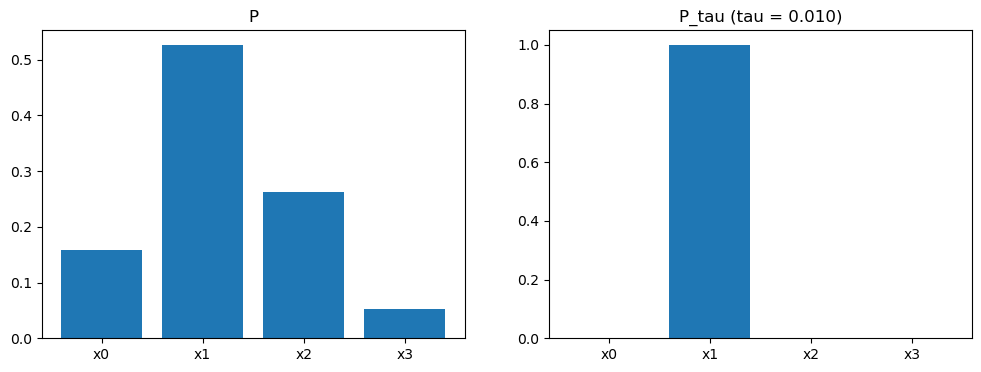

In [70]:
# Temperature
tau = 0.01
P = np.array([3, 10, 5, 1])
P = P / P.sum()
fix, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].bar([f"x{d}" for d in range(len(P))], P)
axs[0].title.set_text("P")
Pt = np.power(P, 1/tau)
Pt = Pt / Pt.sum()
axs[1].bar([f"x{d}" for d in range(len(Pt))], Pt)
axs[1].title.set_text(f"P_tau (tau = {tau:.3f})")

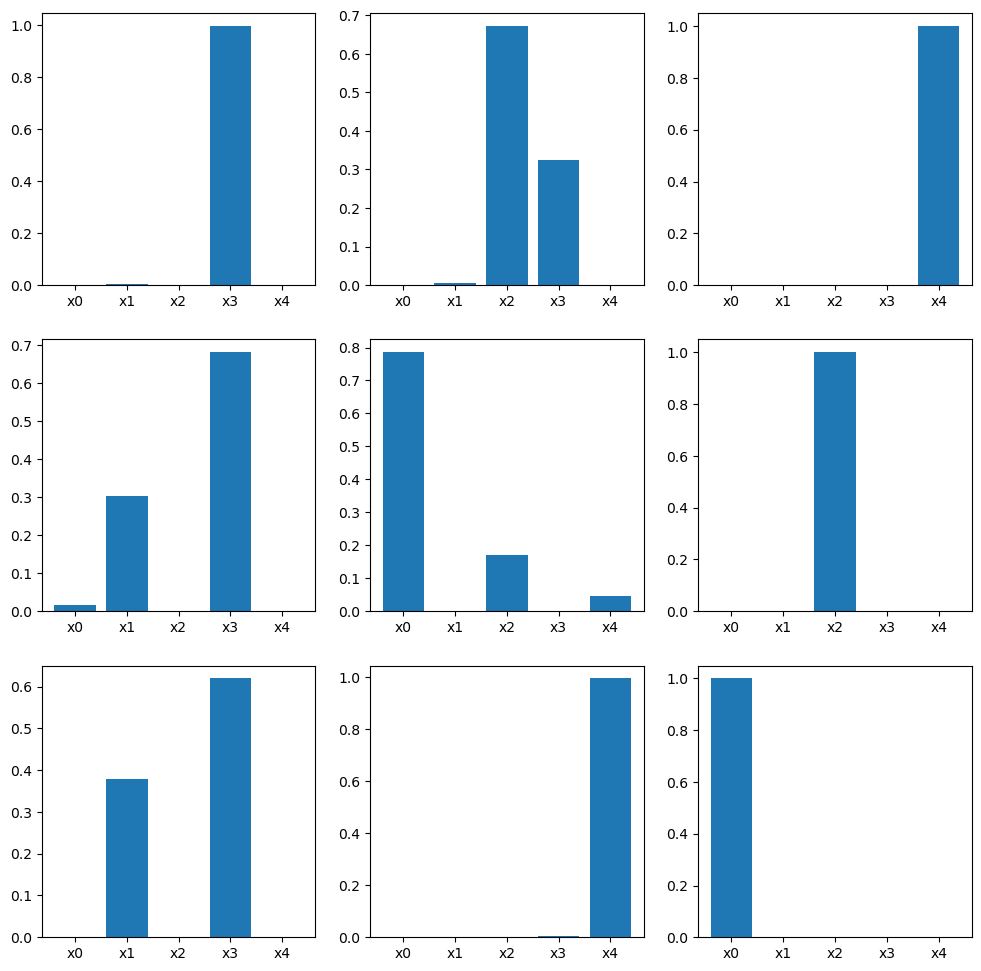

In [82]:
alpha = 0.03

fix, axs = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    for j in range(3):
        D = np.random.dirichlet([alpha] * 5)
        axs[i][j].bar([f"x{d}" for d in range(len(D))], D)


<BarContainer object of 100 artists>

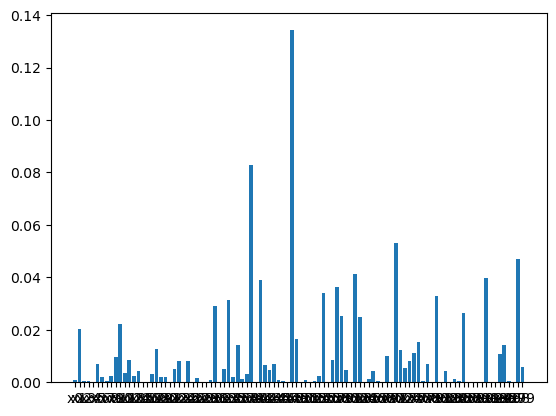

In [85]:
alpha = 0.3

D = np.random.dirichlet([alpha] * 100)
plt.bar([f"x{d}" for d in range(len(D))], D)
